<a href="https://colab.research.google.com/github/DirectriX01/miidas/blob/master/A1_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task-2(Image Classification)
**Part A** : Train on the given dataset using a CNN

##1.Setting up the environment


The dataset is uploaded on google drive. We use the `drive.mount()` method to load the dataset into our environment.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The files were  been downloaed from [Dropbox-Dataset](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) and saved on the path `file_list` 

In [2]:
import os 
file_list = sorted(os.listdir('/content/gdrive/MyDrive/train'))

###1.1 Setting up the framework:
 The default tensorflow framework is uninstalled in favor of tensorflow-gpu which is compatible for training in Colab's GPU environment.

In [3]:
!pip uninstall tensorflow  -y 
!pip install tensorflow-gpu &> /dev/null # stable

import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
2.4.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11814872388372313745, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14646682624
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16922865157638520175
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]


###1.2 Packages

* numpy is the main package for scientific computing with Python.

* matplotlib is a library to plot graphs in Python.

* Keras API will be used for training the model

* cv2 - OpenCv is an library built for various computer vision functions

In [23]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model
#The ImageDataGenerator is an inbuilt function which will help us with image pre-processing 
from  keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

##2.Exploring Dataset



In [9]:
len(os.listdir('/content/gdrive/MyDrive/train'))
!ls '/content/gdrive/MyDrive/train'


Sample001  Sample010  Sample019  Sample028  Sample037  Sample046  Sample055
Sample002  Sample011  Sample020  Sample029  Sample038  Sample047  Sample056
Sample003  Sample012  Sample021  Sample030  Sample039  Sample048  Sample057
Sample004  Sample013  Sample022  Sample031  Sample040  Sample049  Sample058
Sample005  Sample014  Sample023  Sample032  Sample041  Sample050  Sample059
Sample006  Sample015  Sample024  Sample033  Sample042  Sample051  Sample060
Sample007  Sample016  Sample025  Sample034  Sample043  Sample052  Sample061
Sample008  Sample017  Sample026  Sample035  Sample044  Sample053  Sample062
Sample009  Sample018  Sample027  Sample036  Sample045  Sample054


In [10]:
print(len(os.listdir('/content/gdrive/MyDrive/train/Sample001')))
print(os.listdir('/content/gdrive/MyDrive/train/Sample001'))

40
['img001-008.png', 'img001-002.png', 'img001-034.png', 'img001-003.png', 'img001-018.png', 'img001-004.png', 'img001-046.png', 'img001-036.png', 'img001-055.png', 'img001-047.png', 'img001-045.png', 'img001-007.png', 'img001-049.png', 'img001-042.png', 'img001-051.png', 'img001-044.png', 'img001-013.png', 'img001-016.png', 'img001-017.png', 'img001-037.png', 'img001-052.png', 'img001-054.png', 'img001-053.png', 'img001-043.png', 'img001-014.png', 'img001-024.png', 'img001-019.png', 'img001-010.png', 'img001-001.png', 'img001-030.png', 'img001-011.png', 'img001-026.png', 'img001-033.png', 'img001-012.png', 'img001-025.png', 'img001-029.png', 'img001-021.png', 'img001-009.png', 'img001-050.png', 'img001-027.png']


###2.1 Dataset Structure:
  *   There are 62 image classes([0..9],[a..z],[A...Z])
  *   Each class has 40 images
  *   We have 2480 Training images





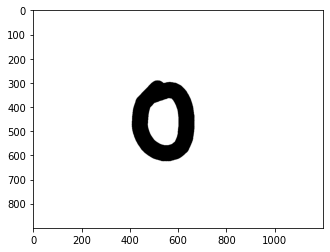

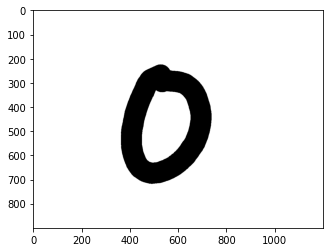

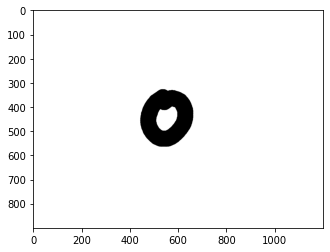

In [11]:
for image in os.listdir('/content/gdrive/MyDrive/train/Sample001')[:3]:
  img = mpimg.imread(os.path.join('/content/gdrive/MyDrive/train/Sample001',image))
  imgplot = plt.imshow(img)
  plt.show()

###2.2 Preprocessing:

*   As we observe there is alot of whitespace around the digits and alphabets, which is unnecessary information for training. Therefore needs to be cropped or zoomed.
*   Since the dataset is small we can go for cropping and we will manipulate the images using opencv. OpenCV is a library of programming functions mainly aimed at real-time computer vision. We shall use `cv2.threshold`,`cv2.findContours`,`cv2.boundingRect` to get a bouding box around our object of interest(digits or alphabet)

Short descriptions of the ```cv2.functions()``` used:
*   **cv2.threshold**: Used for thresholding pixel values if the image intensity is greater than a constant. This functions takes input of a grayscale image *only*. 

  >value, thresh = cv2.threshold(img_source, thresh, maxValue, cv2.THRESH_BINARY+cv.THRESH_OTSU)
    
    Otsu's method`cv2.THRESH_OTSU` avoids having to choose a value and determines it automatically
*   **cv2.findContours**: Contours are lines joining the pixels of same intensity along a boundary. This function accepts binary images *only*. Since we don't have any object inside our objects(digits and alphabets), we won't be needing the `hierarchy` values.

  >contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  *   cv2.RETR_EXTERNAL: retrieves only the extreme outer contours
  *   CHAIN_APPROX_SIMPLE: compresses horizontal, vertical, and diagonal segments and leaves only their end points

*   **cv2.boundingRect**: returns values of bounding rectangle 

  >x,y,w,h = cv2.boundingRect(countour) 





In [12]:
path = '/content/gdrive/MyDrive/train'
dirs = os.listdir(path)
# print(list(dirs))
path2 ='/content/gdrive/MyDrive/Train_Crop'
if not(os.path.exists(path2)):
  os.mkdir(path2)
  for dir_name in dirs:
    img_list = os.listdir(os.path.join(path,dir_name))
    os.mkdir(os.path.join(path2,dir_name))
    # print(img_list)
    for img in img_list:
      # print(img)
      image = cv2.imread(os.path.join(path,dir_name,img))
      original = image.copy()
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

      cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cnts = cnts[0] if len(cnts) == 2 else cnts[1]
      x,y,w,h = cv2.boundingRect(cnts[0])
      cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
      ROI = original[y:y+h, x:x+w]
      cv2.imwrite(os.path.join(path2,dir_name,img), ROI)
      # cv2_imshow(image)


###2.3 Loading the dateset and final preprocessing:
* **Preprocessing images**

  Keras inbuilt `ImageDataGenerator(**args, **kwargs)` class provides various techniques for image preprocessing. We shall proceed with this to augment our dataset. More  can be found here: [ImageDataGenerator Documentation](https://keras.io/api/preprocessing/image/#imagedatagenerator-class)

* **Loading the dataset**

  Keras inbuilt `flow_from_directory(**args, **kwargs)` method Takes the path to a directory & generates batches of augmented data. If no labels are specified then the directory names are taken as labels. More can be found here: [flow_from_directory Documentation](https://keras.io/api/preprocessing/image/#flowfromdirectory-method)


In [13]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path2, target_size=(227,227), class_mode='categorical')

Found 2480 images belonging to 62 classes.


In [14]:
print("Batch Size for Input Image : ",train[0][0].shape)
print("Image Size of first image : ",train[0][0][0].shape)

Batch Size for Input Image :  (32, 227, 227, 3)
Image Size of first image :  (227, 227, 3)


Text(0.5, 1.0, '(array([0]),)')

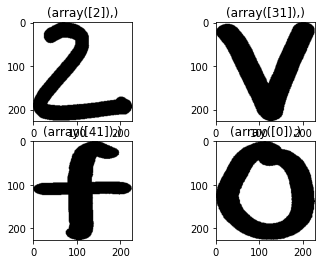

In [17]:
fig , axs = plt.subplots(2,2)

axs[0][0].imshow(train[0][0][12])
axs[0][0].set_title(np.where(train[0][1][12]==1))

axs[0][1].imshow(train[0][0][10])
axs[0][1].set_title(np.where(train[0][1][10]==1))

axs[1][0].imshow(train[0][0][3])
axs[1][0].set_title(np.where(train[0][1][3]==1))

axs[1][1].imshow(train[0][0][6])
axs[1][1].set_title(np.where(train[0][1][6]==1))

## **3.Architecture of your model:**

AlexNet is an 8 layer deep neural network, since we are classifying digits and alphabets, we don't need many feature representation. Therefore we can avoid architectures such as ResNet-50 which is 50 layers deep.

An overlay of the model given is found below([source](https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/)):


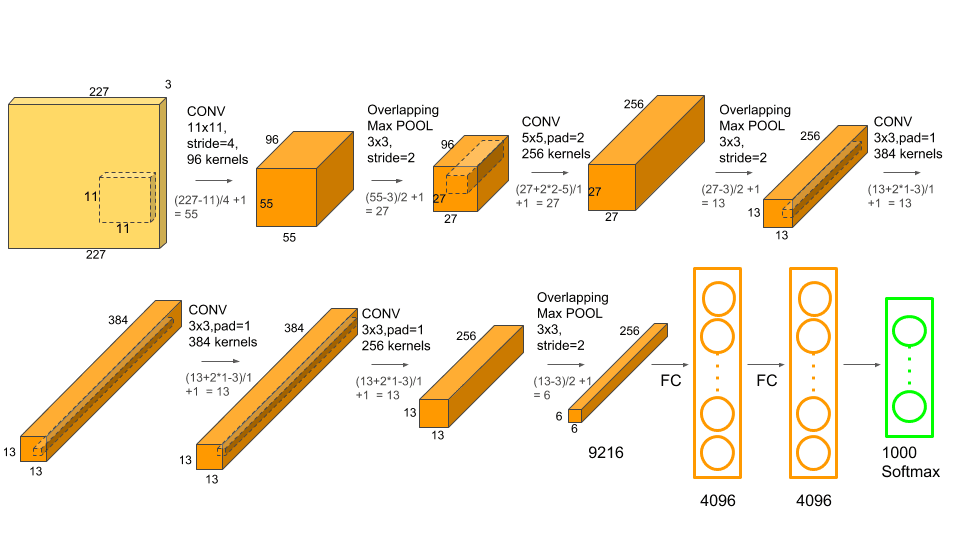

In [18]:
def AlexNet(input_shape):
    
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    X = Dense(62,activation='softmax',name = 'fc2')(X)
    
    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    
    return model

##**4.Training the model**

---

In [19]:
alex = AlexNet(train[0][0].shape[1:])

In [20]:
alex.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv0 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 55, 55, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max0 (MaxPooling2D)          (None, 27, 27, 96)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 27, 27, 256)       614656    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 27, 27, 256)       1024

###**4.1 Compiling the model**
  * Optimizer: Adam Optimizer: It is similar to RMS Prop and has worked well in wide range of deep learning applications
  * Loss: Categorical crossentropy

In [21]:
alex.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

###**4.2 Training the model**
  * Epoch: 50. A higher number of epochs might lead to overfitting of the data.

In [22]:
alex.fit_generator(train,epochs=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
78/78 [==============================] - 783s 10s/step - loss: 19.0052 - accuracy: 0.0499
Epoch 2/50
78/78 [==============================] - 10s 122ms/step - loss: 2.1881 - accuracy: 0.3588
Epoch 3/50
78/78 [==============================] - 10s 123ms/step - loss: 1.3952 - accuracy: 0.5693
Epoch 4/50
78/78 [==============================] - 10s 123ms/step - loss: 0.9954 - accuracy: 0.6741
Epoch 5/50
78/78 [==============================] - 10s 122ms/step - loss: 0.8417 - accuracy: 0.7161
Epoch 6/50
78/78 [==============================] - 9s 120ms/step - loss: 0.6369 - accuracy: 0.7727
Epoch 7/50
78/78 [==============================] - 9s 121ms/step - loss: 0.6336 - accuracy: 0.7614
Epoch 8/50
78/78 [==============================] - 10s 121ms/step - loss: 0.4873 - accuracy: 0.8224
Epoch 9/50
78/78 [==============================] - 10s 124ms/step - loss: 0.4490 - accuracy: 0.8410
Epoch 10/50
78/78 [==============================] - 10s 122ms/step - loss: 0.3726 - accuracy

###**4.3 Post training observations**
  * The accuracy increases alternatively, this goes well from the fact we are using mini batch gradient descent which trains the model faster, however a uniform convergence is not expected.
  * The losses decrease over time so there is less overfitting

In [26]:
path_test = '/content/gdrive/MyDrive/Parap'
predict_datagen = ImageDataGenerator(rescale=1. / 255)
predict = predict_datagen.flow_from_directory(path_test, target_size=(227,227), batch_size = 1,class_mode='categorical')
predictions = alex.predict(predict)
print(len(predictions))

Found 40 images belonging to 1 classes.
40


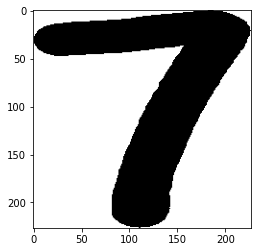

In [28]:
plt.imshow(predict[5][0][0])

In [29]:
def get_category(predicted_output):
    path ='/content/gdrive/MyDrive/Train_Crop'
    s = sorted(os.listdir(path))
    return s[np.argmax(predicted_output)]

In [30]:
print(get_category(predictions[6]))

Sample008


###4.4 Saving the model


In [31]:
alex.save('/content/gdrive/MyDrive/Checkpoints/partA_train_model.h5')
alex.save_weights('/content/gdrive/MyDrive/Checkpoints/partA_train_weights.h5')

## **5.Testing** 

###5.1 Preprocessing test set

In [ ]:
test_path = '/to/your/path'
dirs = os.listdir(path)
# print(list(dirs))
test_path2 ='/to/your/Train_Crop'
if not(os.path.exists(path2)):
  os.mkdir(path2)
  for dir_name in dirs:
  img_list = os.listdir(os.path.join(path,dir_name))
  os.mkdir(os.path.join(path2,dir_name))
  # print(img_list)
  for img in img_list:
    # print(img)
    image = cv2.imread(os.path.join(path,dir_name,img))
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    x,y,w,h = cv2.boundingRect(cnts[0])
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = original[y:y+h, x:x+w]
    cv2.imwrite(os.path.join(path2,dir_name,img), ROI)
    # cv2_imshow(image)

###5.2 Testing

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path2, target_size=(227,227), class_mode='categorical')

In [ ]:
alex.evaluate(train)